In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [14]:
import os

for i in range(9):

    txt_dir, name = os.path.split('/Users/max/Desktop/debug/hypername')
    txt_name = name + '_accuracies.txt'

    txt_file = open(os.path.join(txt_dir,txt_name), 'a')
    txt_file.write(str(i) + '\n')
    
    txt_file.close()

In [7]:
name

'123'

In [169]:
def rgb2gray(images):
    return 0.299*images[:, :, :, 0] + 0.587*images[:, :, :, 1] + 0.114*images[:, :, :, 2]


# call it as 'loss = ... + torch.mean(fourier_dissimilarity(fake_images, real_images, metric))'
# metric can be one of the following: '1' (1-norm of difference),
#                                     '2' (frobenius norm of difference),
#                                     'cos' (cosine dissimilarity)
def fourier_dissimilarity(fake_images, real_images, metric, thres=1):
    #fake_images = fake_images.permute(0, 2, 3, 1)
    #real_images = real_images.permute(0, 2, 3, 1)
    fake_ft = torch.norm(torch.rfft(rgb2gray(fake_images), signal_ndim=2), dim=3)
    real_ft = torch.norm(torch.rfft(rgb2gray(real_images), signal_ndim=2), dim=3)
    if metric == '1':
        return torch.norm(fake_ft[:,thres:-thres,thres:]-real_ft[:,thres:-thres,thres:], p=1, dim=(1, 2))*1e-6
    elif metric == '2':
        return torch.norm(fake_ft[:,thres:-thres,thres:]-real_ft[:,thres:-thres,thres:], p='fro', dim=(1, 2))*1e-4
    elif metric == 'cos':
        vec_fake_ft = torch.flatten(fake_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=1)
        vec_real_ft = torch.flatten(real_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=2)
        return 1 - torch.bmm(vec_fake_ft, vec_real_ft).squeeze() / (torch.norm(vec_fake_ft, dim=2) * torch.norm(vec_real_ft, dim=1)).squeeze()
    else:
        return 0

In [165]:
# read images
path = 'style_gan_idinvert_images/'

original_list = []
enc_list = []
opt_list = []

for ii in range(4):
    original_list.append(plt.imread(path+'original/'+str(ii)+'.jpg'))
    enc_list.append(plt.imread(path+'enc/'+str(ii)+'.jpg'))
    opt_list.append(plt.imread(path+'opt/'+str(ii)+'.jpg'))
    
original = torch.from_numpy(np.array(original_list))
enc = torch.from_numpy(np.array(enc_list))
opt = torch.from_numpy(np.array(opt_list))

In [126]:
original.shape

torch.Size([4, 256, 256, 3])

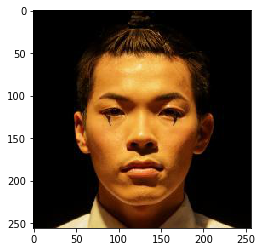

In [127]:
plt.imshow(original[0])

In [128]:
original_ft = torch.norm(torch.rfft(rgb2gray(original), signal_ndim=2), dim=3)
enc_ft = torch.norm(torch.rfft(rgb2gray(enc), signal_ndim=2), dim=3)
opt_ft = torch.norm(torch.rfft(rgb2gray(opt), signal_ndim=2), dim=3)

In [146]:
thres = 1
original_ft[:,thres:-thres,thres:].shape

torch.Size([4, 254, 128])

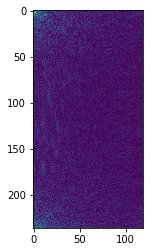

In [163]:
thres = 10
plt.imshow(original_ft[2,thres:-thres,thres:])

In [170]:
fd_enc_2 = np.round(fourier_dissimilarity(original, enc, '2').numpy())
fd_enc_1 = np.round(fourier_dissimilarity(original, enc, '1').numpy())
fd_enc_cos = np.round(10000*fourier_dissimilarity(original, enc, 'cos').numpy())/10000

In [171]:
fd_opt_2 = np.round(fourier_dissimilarity(original, opt, '2').numpy())
fd_opt_1 = np.round(fourier_dissimilarity(original, opt, '1').numpy())
fd_opt_cos = np.round(10000*fourier_dissimilarity(original, opt, 'cos').numpy())/10000

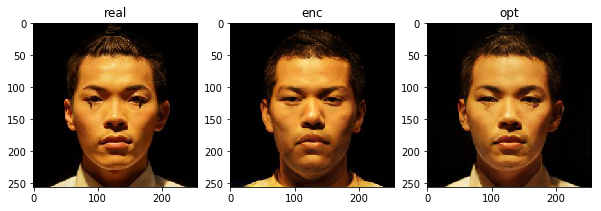

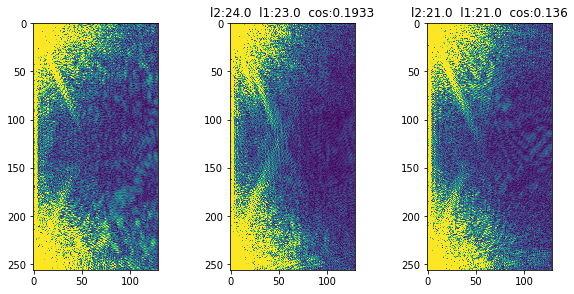

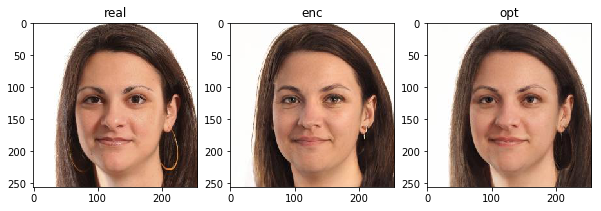

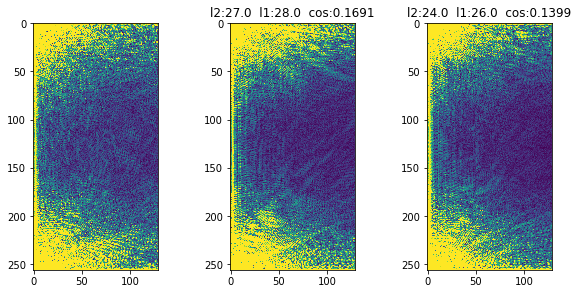

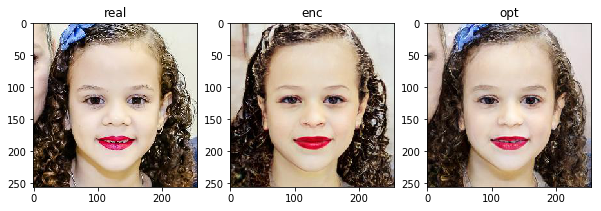

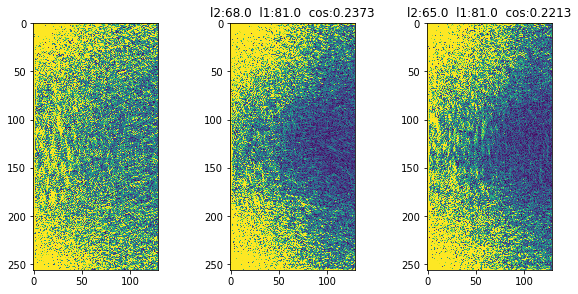

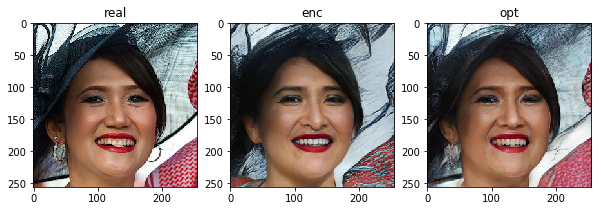

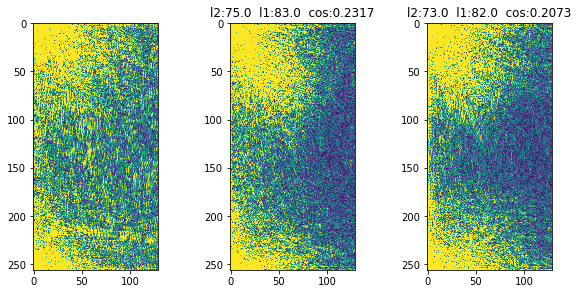

In [172]:
for ii in range(original.shape[0]):
    # images
    figure(figsize=(10,10))
    ax1 = plt.subplot(2,3,1)
    ax1.set_title('real')
    plt.imshow(original[ii])
    ax2 = plt.subplot(2,3,2)
    ax2.set_title('enc')
    plt.imshow(enc[ii])
    ax3 = plt.subplot(2,3,3)
    ax3.set_title('opt')
    plt.imshow(opt[ii])
    # spectra
    figure(figsize=(10,10))
    ax1 = plt.subplot(2,3,4)
    plt.imshow(torch.minimum(1*torch.mean(original_ft[ii]),original_ft[ii]))
    ax2 = plt.subplot(2,3,5)
    ax2.set_title('l2:'+str(fd_enc_2[ii])+'  l1:'+str(fd_enc_1[ii])+'  cos:'+str(fd_enc_cos[ii]))
    plt.imshow(torch.minimum(1*torch.mean(enc_ft[ii]),enc_ft[ii]))
    ax3 = plt.subplot(2,3,6)
    ax3.set_title('l2:'+str(fd_opt_2[ii])+'  l1:'+str(fd_opt_1[ii])+'  cos:'+str(fd_opt_cos[ii]))
    plt.imshow(torch.minimum(1*torch.mean(opt_ft[ii]),opt_ft[ii]))